# Deep Network Training

This notebook trains several neural networks to predict seabirds' dives from GPS data.

Dataset: Peruvian Boobies trajectories sampled at 5, 15 and 30s

Network Architecture:

* FCNet : fully connected network (dense layer)
* CNNet : basic convolutional network
* UNet : U-Network with convolutional layers



## connect to drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

%cd drive/My\ Drive/THESIS/BirdDL

## data & libraries

In [ ]:
!pip install pytorch-lightning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from utils.dataloader import *
from utils.model import *

In [ ]:
data_train = pd.read_csv('./data/SD_train.csv')
data_validation = pd.read_csv('./data/SD_validation.csv')
data_test = pd.read_csv('./data/SD_test.csv')

In [ ]:
resolution = 15

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

# Nb traj = 1

In [ ]:
nb = 1

train_select = train[train.trip.isin(train.trip.unique()[:nb])]

### FCNet

In [ ]:
## Dataloader
window = 21
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 30

train_set = TrajDataSet(train_select, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model Training
%%time

model = Lightning(FCNet(window, len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SD_'+model.model.name+'_'+str(nb)+'--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 0,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)


trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1567: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."

  | Name  | Type  | Params

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 9min 6s, sys: 3.25 s, total: 9min 9s
Wall time: 9min 6s


0.8070620529983495


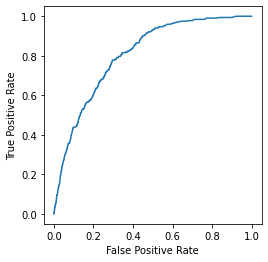

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=FCNet(window, len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['FCNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### CNNet

In [ ]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 30

train_set = TrajDataSet(train_select, window, variable, transform=ToTensor())
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model training
%%time

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SD_'+model.model.name+'_'+str(resolution)+'--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | CNNet | 3.6 K 
--------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.015     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 9min 54s, sys: 4.44 s, total: 9min 59s
Wall time: 10min 1s


0.9304937075921511


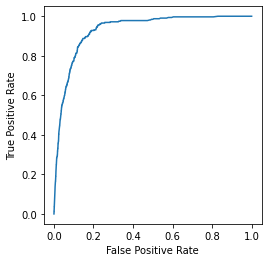

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=CNNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['CNNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### UNet

In [ ]:
## Model training
%%time

model = Lightning(UNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'SD_'+model.model.name+'_'+str(resolution)+'--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 18.9 K
-------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pyt

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 7min 27s, sys: 2.5 s, total: 7min 30s
Wall time: 7min 27s


0.9093352856225931


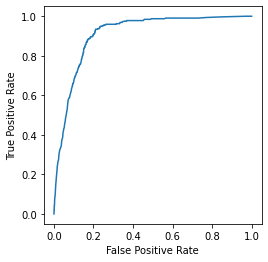

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=UNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['UNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))